In [19]:
import pandas as pd

from phase_2.scripts.strategies.trend.trend_strategy_v1 import run_trend_strategy_v1
from phase_2.scripts.strategies.meanrev.meanrev_strategy_v1 import run_meanrev_strategy_v1
from phase_2.scripts.strategies.meta.meta_allocator_v1 import build_regime_features, build_meta_raw_returns
from phase_2.scripts.strategies.meta.risk_targeting_v1 import apply_vol_targeting

spy = pd.read_parquet("../data/processed/spy_daily.parquet")
spy["date"] = pd.to_datetime(spy["date"])
spy["year"] = spy["date"].dt.year

train = spy[spy["year"] < 2016].copy()
test = spy[spy["year"] == 2016].copy()


In [20]:
trend_out = run_trend_strategy_v1(test, train_df=train)
meanrev_out = run_meanrev_strategy_v1(test)
regime = build_regime_features(test)

meta = build_meta_raw_returns(trend_out, meanrev_out, regime)
meta.head()


,date,state,meta_raw_ret
0,2016-01-04,CASH,0.0
1,2016-01-05,CASH,0.0
2,2016-01-06,CASH,0.0
3,2016-01-07,CASH,0.0
4,2016-01-08,CASH,0.0


In [21]:
vt = apply_vol_targeting(meta["meta_raw_ret"], target_vol_annual=0.10, max_leverage=1.0)
meta["lev"] = vt["lev"]
meta["meta_ret"] = vt["meta_ret"]

meta.head()


,date,state,meta_raw_ret,lev,meta_ret
0,2016-01-04,CASH,0.0,0.0,0.0
1,2016-01-05,CASH,0.0,0.0,0.0
2,2016-01-06,CASH,0.0,0.0,0.0
3,2016-01-07,CASH,0.0,0.0,0.0
4,2016-01-08,CASH,0.0,0.0,0.0


In [22]:
meta["state"].value_counts(normalize=True)


state
TREND      0.583333
CASH       0.392857
MEANREV    0.023810
Name: proportion, dtype: float64

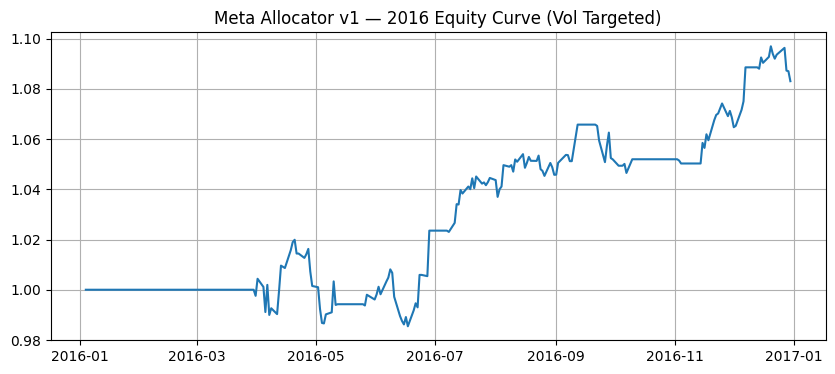

In [23]:
import matplotlib.pyplot as plt

equity = (1 + meta["meta_ret"]).cumprod()

plt.figure(figsize=(10,4))
plt.plot(meta["date"], equity)
plt.title("Meta Allocator v1 — 2016 Equity Curve (Vol Targeted)")
plt.grid(True)
plt.show()


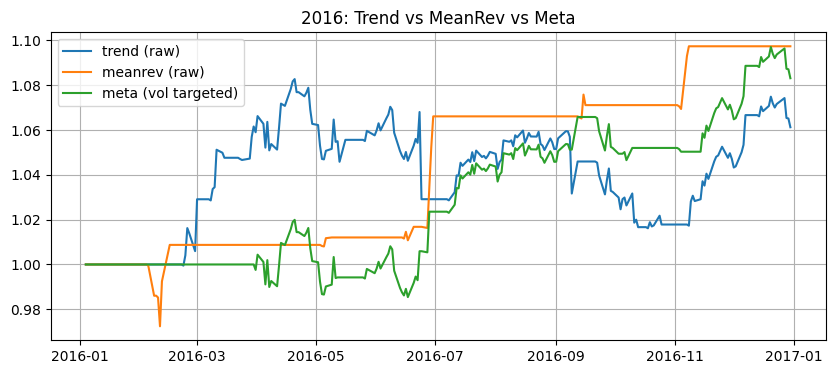

In [24]:
import matplotlib.pyplot as plt

trend_eq = (1 + trend_out["raw_ret"]).cumprod()
mr_eq = (1 + meanrev_out["raw_ret"]).cumprod()
meta_eq = (1 + meta["meta_ret"]).cumprod()

plt.figure(figsize=(10,4))
plt.plot(test["date"], trend_eq, label="trend (raw)")
plt.plot(test["date"], mr_eq, label="meanrev (raw)")
plt.plot(meta["date"], meta_eq, label="meta (vol targeted)")
plt.legend()
plt.title("2016: Trend vs MeanRev vs Meta")
plt.grid(True)
plt.show()
